# Overfitting and Regularization

## Imports

In [343]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [344]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config
from sklearn.compose import ColumnTransformer
import warnings 

In [345]:
set_config(display='diagram')

## Settings

In [346]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [347]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

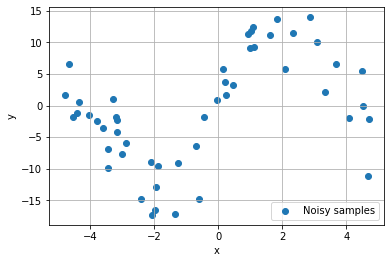

In [348]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

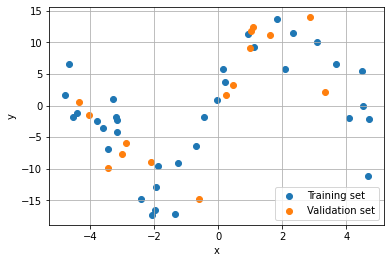

In [349]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [350]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [351]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [352]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=200000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=200000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=200000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=200000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

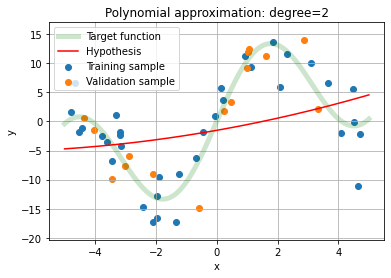

In [353]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

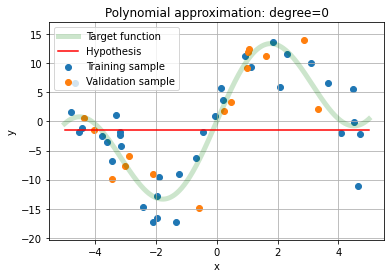

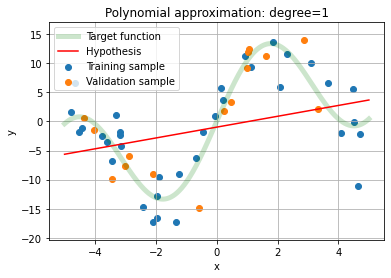

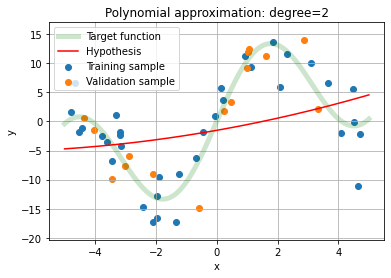

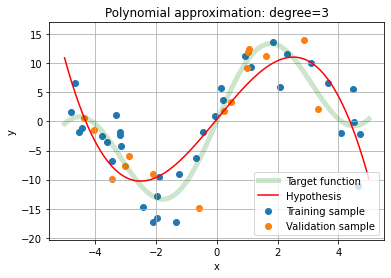

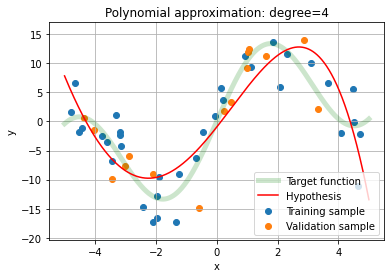

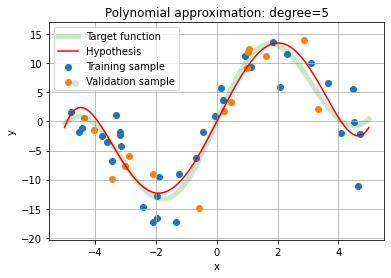

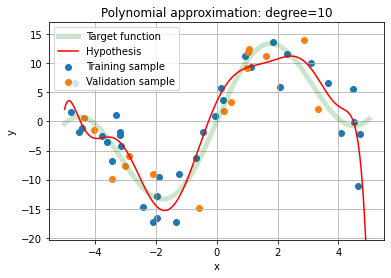

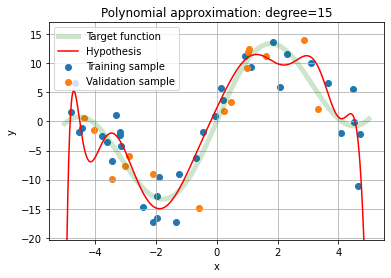

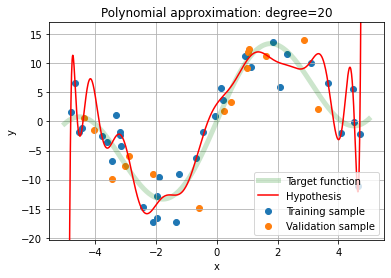

In [354]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

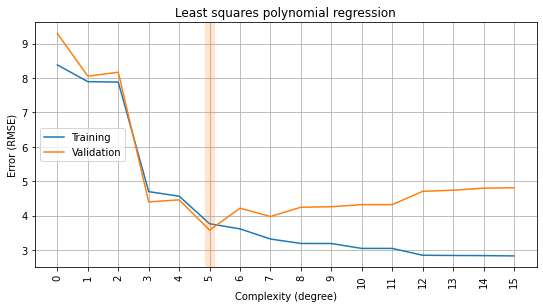

In [355]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [356]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

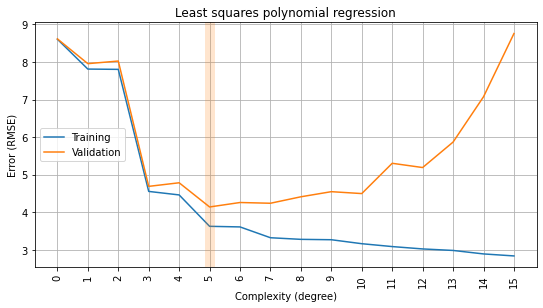

In [357]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [358]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

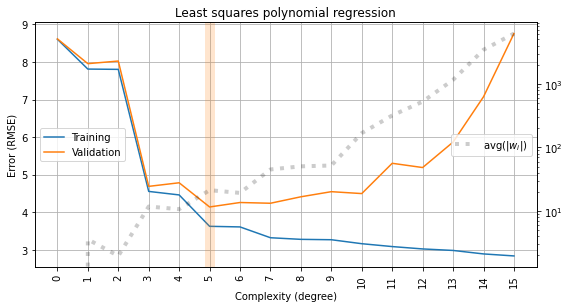

In [359]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

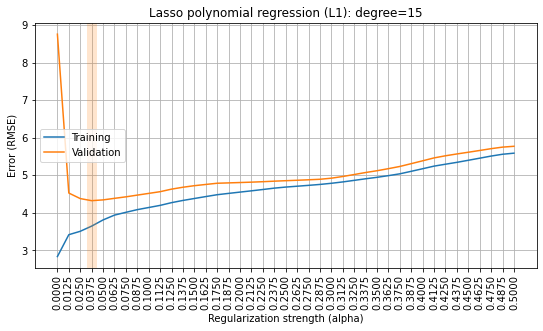

In [360]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

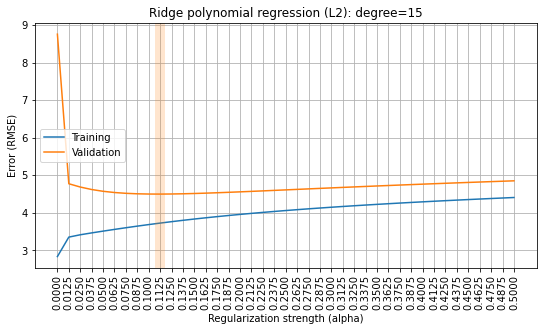

In [361]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

#### WARNING!

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you must collect all features together (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [362]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [363]:
X_diabetes.head(5)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


In [364]:
y_diabetes.head(5)

,target
0,151.0
1,75.0
2,141.0
3,206.0
4,135.0


Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

In [365]:
# Придется сделать свою модель
def make_my_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=100000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=100000) 
    
    pipe = Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0)))
    ])
    
    categorical = ['age', 'sex']
    preprocessor = ColumnTransformer([('cat', pipe, categorical)], remainder='passthrough')
    
    return Pipeline([
        ('preprocessor', preprocessor),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_my_model(2))
display(make_my_model(2, penalty='L1', alpha=0.1))
display(make_my_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('pol',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['age', 'sex'])])),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('pol',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['age', 'sex'])])),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=100000, random_state=42))])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('pol',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['age', 'sex'])])),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=100000, random_state=42))])

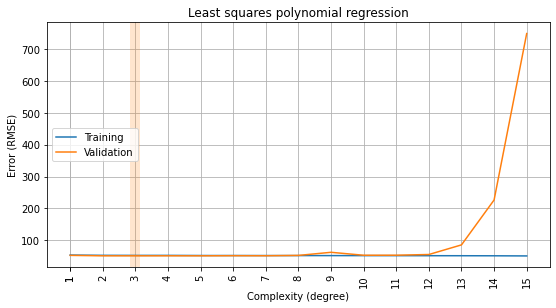

3

In [366]:
# Примените модель для набора данных по диабету с полиномиальным проектированием признаков разной степени. 
# Постройте зависимость ошибки выборки обучения и теста от степени полинома. 
# Выделите степень с наилучшей ошибкой теста. Какие степени вызывают переобучение/недообучение? Почему?
# your findings/conclusions

X_train_my, X_valid_my, y_train_my, y_valid_my = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)

DEGREES = np.linspace(1, 15, 1 + 15, dtype=int)

rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_my_model(degree).fit(X_train_my, y_train_my)
    rmse_train.append(rmse(reg.predict(X_train_my), y_train_my))
    rmse_valid.append(rmse(reg.predict(X_valid_my), y_valid_my))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

DEGREES[np.argmin(rmse_valid)]

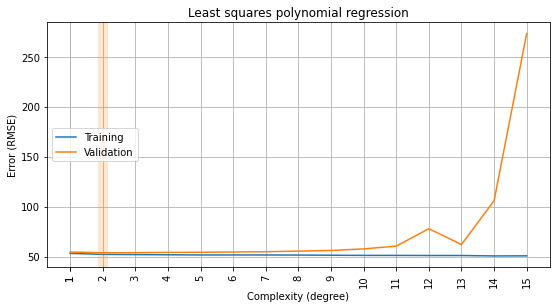

In [367]:
rmse_train_2, rmse_valid_2 = [], []
for degree in DEGREES:
    results = cross_validate(make_my_model(degree),                              
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train_2.append(-np.mean(results['train_score']))
    rmse_valid_2.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train_2, rmse_valid_2, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

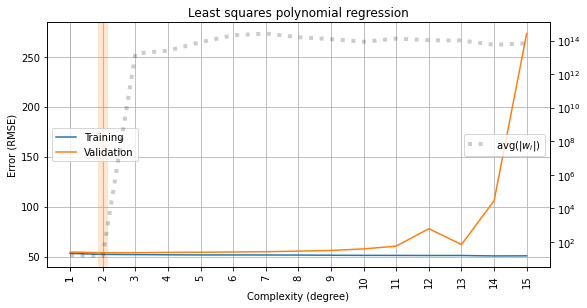

In [368]:
rmse_train_3, rmse_valid_3, avg_coef_3 = [], [], []
for degree in DEGREES:
    results = cross_validate(make_my_model(degree),                             
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train_3.append(-np.mean(results['train_score']))
    rmse_valid_3.append(-np.mean(results['test_score']))        
    avg_coef_3.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train_3, rmse_valid_3,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_3, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

In [369]:
# Вообще, если НЕ на своей модели, то я получала degree = 1 лучшим, но тут я всего 2 признака полиномизирую, 
# наверно поэтому degree = 2
# степени degree < 2 вызывают недообучение, а степени degree > 2 вызывают переобучение
# это видно, т.к. при увеличении степени degree увеличивается и ошибка RMSE для Validation
# Больше верим графикам с кросс-валидацией (2,3) чем без нее (1).

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

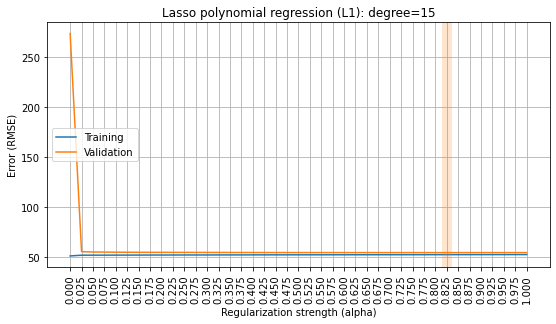

0.8250000000000001

In [370]:
## your code
ALPHAS = np.linspace(0, 1.0, 1 + 40)

rmse_train_4, rmse_valid_4 = [], []
for alpha in ALPHAS:    
    results_L1 = cross_validate(make_my_model(degree=15, penalty='L1', alpha=alpha), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train_4.append(-np.mean(results_L1['train_score']))
    rmse_valid_4.append(-np.mean(results_L1['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train_4, rmse_valid_4,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

ALPHAS[np.argmin(rmse_valid_4)]

In [371]:
array_l1 = make_model(15, penalty='L1', alpha=0.825).fit(X_hw, y_hw)['reg'].coef_
array_l1

array([ 4.30837327,  0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.        , -0.  

#### L2

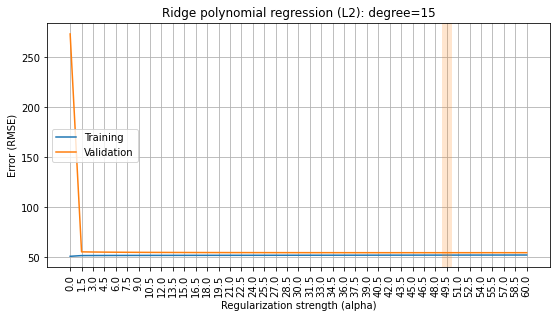

49.5

In [372]:
## your code
ALPHAS = np.linspace(0, 60.0, 1 + 40)

rmse_train_5, rmse_valid_5 = [], []
for alpha in ALPHAS:    
    results_L2 = cross_validate(make_my_model(degree=15, penalty='L2', alpha=alpha), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train_5.append(-np.mean(results_L2['train_score']))
    rmse_valid_5.append(-np.mean(results_L2['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train_5, rmse_valid_5, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')


ALPHAS[np.argmin(rmse_valid_5)]

In [373]:
array_l2 = make_model(15, penalty='L2', alpha=49.5).fit(X_hw, y_hw)['reg'].coef_
array_l2

array([ 8.59794279e-01, -3.22633465e-02, -9.58166116e-02,  1.87591491e-01,
       -3.38967599e-01,  6.17205800e-01,  3.85838240e-01,  7.81703828e-02,
        5.05133311e-02,  4.99586038e-01,  4.92969141e-02,  9.27960220e-02,
        3.01834885e-01, -1.09786892e-01,  4.66019449e-01, -1.94434680e-01,
        7.61424852e-02,  4.97812362e-02,  6.19705876e-02,  7.73651790e-02,
       -1.68324195e-01,  3.26289405e-01,  1.79921923e-01,  9.94690250e-02,
        1.05098681e-01, -1.02831898e-01,  1.46117119e-01, -9.07048167e-02,
        3.36362977e-01,  1.37264236e-01, -9.48720908e-02,  4.67677985e-02,
        4.65442870e-02,  4.58590293e-02,  3.08747834e-01,  7.38137412e-02,
        8.62068163e-02,  1.55804278e-01, -3.69017012e-02,  2.05603085e-01,
       -8.45832625e-02,  1.42726302e-02,  5.44586301e-02,  8.36195302e-02,
        1.61590285e-01,  4.07849139e-02,  1.17406484e-01, -7.56399975e-02,
        2.41551946e-01, -1.15351460e-01, -8.03304854e-03, -6.97526683e-02,
        2.28636899e-02,  

#### Summary

In [374]:
## your observations/conclusions
# Как обсуждалось ранее, ожидается, что методы регуляризации будут ограничивать веса (коэффициенты модели).
# Это действительно происходит?

# Судя по coef методы Lasso и Ridge дали нам нормальные адекватные коэффициенты, 
# несмотря на degree=15, где ошибка валидации очень высока.
# Значит методы регуляризаци Lasso и Ridge действительно ограничивают веса (коэффициенты модели).

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [375]:
## your code
print(f'Quantity with 0: {array_l1.size - np.count_nonzero(array_l1)}') # 811
print(f'Quantity without 0: {np.count_nonzero(array_l1)}') # 4

Quantity with 0: 811
Quantity without 0: 4


#### L2

In [376]:
## your code
print(f'Quantity with 0: {array_l2.size - np.count_nonzero(array_l2)}') # 0
print(f'Quantity without 0: {np.count_nonzero(array_l2)}') # 815

Quantity with 0: 0
Quantity without 0: 815


#### Summary

In [377]:
# your findings/conclusions

# L1 может уменьшить коэффициенты некоторых признаков до 0, тем самым косвенно реализуя выбор признаков. 
# Таким образом, L1 подходит для ситуаций, когда существует корреляция между функциями.
# L2 уменьшает коэффициенты всех функций, но не до 0, это сделает решение оптимизации стабильным и быстрым. 
# Таким образом, L2 подходит для ситуаций, когда нет корреляции между функциями.

# Получается, что Lasso (L1) как бы вычеркнула ненужные фичи, присвоив коэффициентам 0. Это видно по 811 нулям 
# и всего 4-ём не нулевым коэффициентам.
# Ridge (L2) так не поступает. Он будет близок к 0, но нулем врят ли будет.

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [378]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


#### L1

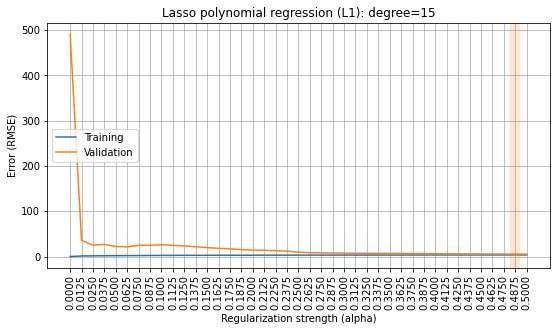

0.48750000000000004

In [379]:
## your code
ALPHAS = np.linspace(0, 0.5, 1 + 40)

rmse_train_8, rmse_valid_8 = [], []
for alpha in ALPHAS:    
    results_L1 = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train_8.append(-np.mean(results_L1['train_score']))
    rmse_valid_8.append(-np.mean(results_L1['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train_8, rmse_valid_8,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

ALPHAS[np.argmin(rmse_valid_8)]

In [380]:
l1_scaled = make_model(15, penalty='L1', alpha=0.4875).fit(X_hw, y_hw)['reg'].coef_

#### L2

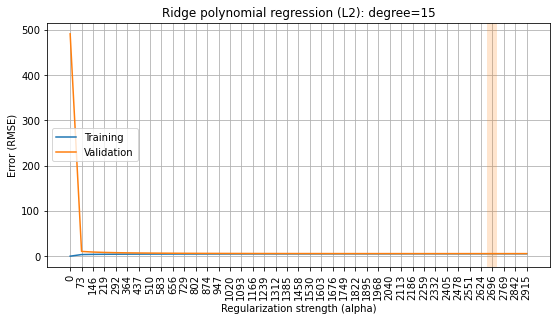

2696.375

In [381]:
## your code
ALPHAS = np.linspace(0, 2915, 1 + 40)

rmse_train_9, rmse_valid_9 = [], []
for alpha in ALPHAS:    
    results_L2 = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train_9.append(-np.mean(results_L2['train_score']))
    rmse_valid_9.append(-np.mean(results_L2['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train_9, rmse_valid_9, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

ALPHAS[np.argmin(rmse_valid_9)]

In [382]:
l2_scaled = make_model(15, penalty='L2', alpha=2696.375).fit(X_hw, y_hw)['reg'].coef_

#### Придется сделать свою модель без StandardScaler

In [383]:
# Придется сделать свою модель без StandardScaler
# Пришлось ещё tol=0.01

def make_model_without_scaler(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=200000, tol=0.01)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=200000) 
        
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('reg', regressor)
    ])

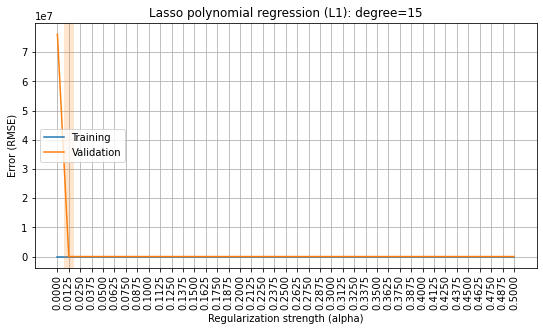

0.0125

In [384]:
# L1
ALPHAS = np.linspace(0, 0.5, 1 + 40)

rmse_train_10, rmse_valid_10 = [], []
for alpha in ALPHAS:    
    results_L1 = cross_validate(make_model_without_scaler(degree=15, penalty='L1', alpha=alpha), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train_10.append(-np.mean(results_L1['train_score']))
    rmse_valid_10.append(-np.mean(results_L1['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train_10, rmse_valid_10,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

ALPHAS[np.argmin(rmse_valid_10)]

In [385]:
l1_not_scaled = make_model(15, penalty='L1', alpha=0.0125).fit(X_hw, y_hw)['reg'].coef_

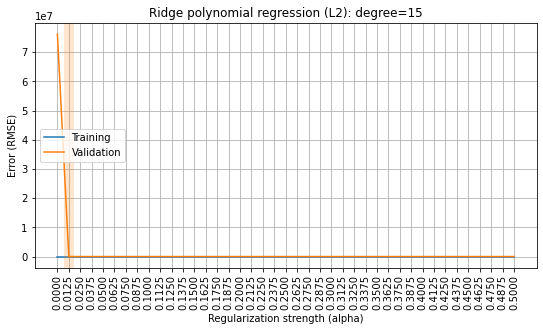

0.0125

In [386]:
# L2
warnings.filterwarnings("ignore")

ALPHAS = np.linspace(0, 0.5, 1 + 40)

rmse_train_11, rmse_valid_11 = [], []
for alpha in ALPHAS:    
    results_L2 = cross_validate(make_model_without_scaler(degree=15, penalty='L2', alpha=alpha), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train_11.append(-np.mean(results_L2['train_score']))
    rmse_valid_11.append(-np.mean(results_L2['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train_11, rmse_valid_11, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

ALPHAS[np.argmin(rmse_valid_11)]

In [387]:
l2_not_scaled = make_model(15, penalty='L2', alpha=0.0125).fit(X_hw, y_hw)['reg'].coef_

#### Summary



In [388]:
l1_scaled 

array([ 4.60597373,  0.        , -0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        ,  0.        , -0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.        , -0.  

In [389]:
l2_scaled 

array([ 6.06596030e-02,  1.83120267e-03, -8.48157784e-03, -5.43977975e-04,
        1.34319585e-03,  5.12600115e-02,  4.80931395e-03,  3.18656470e-03,
       -2.63230236e-03,  5.03806062e-02,  1.43431969e-02, -8.15937208e-03,
        2.82492223e-02,  5.52739055e-03,  4.09904365e-02, -6.08832452e-03,
       -6.51374034e-03,  2.01873387e-03,  1.03335901e-04, -2.08703984e-03,
        5.76286932e-03,  4.25332352e-02,  4.22542907e-03,  1.18422822e-02,
       -8.31536016e-03,  4.84557918e-03,  2.29630894e-02,  5.20767925e-03,
        3.18712798e-02, -3.51499151e-03, -4.27077946e-03, -6.63357516e-03,
        2.55435990e-03,  1.74003212e-03,  4.29319017e-02,  1.80113612e-02,
       -7.23948304e-03,  2.12283903e-02,  7.69487254e-03,  3.29751310e-02,
        2.72345579e-03, -4.58780195e-03,  7.17634602e-03, -7.01078929e-03,
        1.94506232e-02,  6.54634190e-03,  1.94743229e-02,  5.32560872e-03,
        2.50145310e-02, -6.55060492e-03, -1.01562436e-02, -3.31072950e-03,
       -5.43343281e-03,  

In [390]:
l1_not_scaled 

array([ 2.4739419 ,  4.83777115,  0.        ,  1.18133268, -3.80256953,
        0.        ,  3.07945977,  0.        ,  1.72060409,  1.6355687 ,
        0.09566829,  0.        ,  0.        ,  0.        ,  3.64032872,
       -7.50489024,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -1.30823276, -0.        ,  2.36933523,  0.        ,
       -2.31107977, -0.        ,  0.        , -0.        ,  0.        ,
        0.86966728,  0.        ,  0.        , -0.        , -0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        , -5.07214336,  0.        , -0.        ,
       -0.        , -0.        , -0.        ,  4.62581835, -0.        ,
       -0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        ,  0.        , -0.        , -0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.  

In [391]:
l2_not_scaled 

array([-1.87781195e+00,  3.72715856e+00, -7.29356805e+00,  5.93513891e+00,
        1.70809777e+00,  1.76649210e-01, -3.43529621e+00, -3.89695475e+00,
        2.12390325e+00,  3.99959745e+00, -1.55657448e+00,  3.82267295e+00,
       -1.44537902e+00,  1.35859299e+00,  2.90254382e+00,  1.06743195e+00,
        5.36950317e+00, -3.58506589e+00,  4.36438245e+00, -6.71436532e+00,
       -1.79849860e+00, -4.29977763e-01,  1.95097224e+00,  1.18486736e+00,
        1.63144480e+00, -4.11954870e+00, -1.62065279e+00, -1.65772050e+00,
        3.80820808e+00,  3.14712385e+00, -1.39517820e+00,  4.87001995e+00,
        4.09712227e-01,  3.55820998e+00,  5.53198274e+00,  9.58533799e-01,
       -3.34070854e+00,  2.58080108e+00, -1.37350067e-01, -1.95083568e+00,
       -6.35033228e-01, -2.47018631e-01,  1.92071159e+00, -4.68582050e-01,
        2.43209728e+00, -5.15479951e-02, -2.90011979e-01, -3.00138788e+00,
        3.74636056e+00, -3.80130244e+00,  1.43517880e+00, -2.21911316e+00,
        1.27305583e+00,  

In [394]:
print(f'Quantity without 0 l1_scaled: {np.count_nonzero(l1_scaled)}') # 8
print(f'Quantity without 0 l1_not_scaled: {np.count_nonzero(l1_not_scaled)}') # 36

Quantity without 0 l1_scaled: 8
Quantity without 0 l1_not_scaled: 36


In [395]:
## your observations/conclusions
# Важно ли масштабирование? Каковы основные причины?

# Полученные данные содержат в совокупности признаки разного размера и масштаба. 
# Различные масштабы функций данных отрицательно влияют на моделирование набора данных.
# Многие алгоритмы машинного обучения работают лучше или сходятся быстрее, когда функции находятся в относительно 
# одинаковом масштабе или близки к нормальному распределению.

# Стандартизация – это метод масштабирования, при котором данные масштабируются путем преобразования 
# статистического распределения данных в следующий формат: среднее – 0 (ноль); стандартное отклонение – 1.
# Таким образом, весь набор данных масштабируется вместе с нулевым значением и единичной дисперсией.

# По полученным коэффициентам можно наблюдать, что в l1_scaled больше нулевых коэф-тов, чем в l1_not_scaled.
# Поэтому l1_scaled лучше справился с отсеиванием параметров, чем l1_not_scaled.
# Коэффициенты в l2_not_scaled больше по значению (e+00,e-01), чем в l2_scaled (e-03, e-04).
# Так же в l2_not_scaled есть коэф-ты e+00, в l2_scaled таких нет, думаю в этом и выражается неотскалированность данных.
# Т.к. в самом начале нам вывели максимальные и минимальные значения фич:
# Min of feature 0: -0.05, max: 0.05
# Min of feature 1: -494.87, max: 493.57
# Min of feature 2: -2.35, max: 213.31

# Видимо поэтому часть коэф-тов e+00, а часть e-02.